## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import clone
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Reading CSV:

In [2]:
df=pd.read_csv("LendingClub.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (49,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


fraction of NA's for mix_wars:

In [3]:
mix_vars=[49,129,130,131,134,135,136,139]
df.iloc[:,mix_vars].apply(lambda x: x.isna().mean())

next_pymnt_d               0.999913
hardship_type              0.999379
hardship_reason            0.999379
hardship_status            0.999379
hardship_start_date        0.999379
hardship_end_date          0.999379
payment_plan_start_date    0.999379
hardship_loan_status       0.999379
dtype: float64

Dropping mix_vars:

In [4]:
df.drop(df.columns[mix_vars],axis=1,inplace=True)

First look:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413534 entries, 0 to 413533
Columns: 144 entries, id to good_loan
dtypes: float64(69), int64(46), object(29)
memory usage: 454.3+ MB


In [6]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,413534,NaN,NaN,NaN,2.01205e+07,1.31241e+07,57167,8.29579e+06,1.64422e+07,3.23698e+07,4.44091e+07
member_id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,413534,NaN,NaN,NaN,14403.2,8266.14,1000,8000,12050,20000,35000
funded_amnt,413534,NaN,NaN,NaN,14403.2,8266.14,1000,8000,12050,20000,35000
funded_amnt_inv,413534,NaN,NaN,NaN,14397.8,8263.23,950,8000,12050,20000,35000
term,413534,2,36 months,318766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,413534,160,12.99%,16547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,413534,NaN,NaN,NaN,442.01,247.577,4.93,263.55,385.35,580.73,1409.99
grade,413534,7,B,121329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,413534,35,B4,27056,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropping vars from doc:

In [9]:
doc_vars=["funded_amnt","last_fico_range_high","last_fico_range_low","last_credit_pull_d", "total_pymnt", "total_rec_prncp", 
         "total_rec_int", "last_pymnt_amnt", "last_pymnt_d", "out_prncp", "out_prncp_inv", "pymnt_plan", "hardship_flag",
          "hardship_amount", "debt_settlement_flag",
          "debt_settlement_flag_date", "settlement_percentage"]

In [10]:
df.drop(doc_vars,axis=1,inplace=True)

"emp_title" has a big amount of unique categorical values. "Zip_code" has a big amount of unique values and is unnesessary, because there is addr_state variable.
We'll drop those variables.

In [11]:
drop_vars=[]

In [12]:
drop_vars=drop_vars+["emp_title","zip_code","id","url"]
drop_vars

['emp_title', 'zip_code', 'id', 'url']

"title" variable repeats "puprpose" and contains much noise(useless informatrion). We'll drop it.

In [13]:
df["purpose"].value_counts(normalize=True)

debt_consolidation    0.603890
credit_card           0.237209
home_improvement      0.054153
other                 0.044942
major_purchase        0.016719
small_business        0.009789
medical               0.008928
car                   0.008009
moving                0.005528
vacation              0.004998
house                 0.003898
wedding               0.001432
renewable_energy      0.000505
Name: purpose, dtype: float64

In [14]:
df["title"].value_counts(normalize=True)[0:20]

Debt consolidation           0.455342
Credit card refinancing      0.173753
Home improvement             0.040135
Other                        0.035274
Debt Consolidation           0.021578
Major purchase               0.012664
Consolidation                0.008464
Business                     0.008203
Medical expenses             0.007506
debt consolidation           0.007013
Car financing                0.005961
Moving and relocation        0.004321
Vacation                     0.004174
consolidation                0.003415
Credit Card Consolidation    0.003340
Home buying                  0.002646
Debt Consolidation Loan      0.002532
Consolidation Loan           0.002525
Home Improvement             0.002285
Credit Card Refinance        0.002123
Name: title, dtype: float64

In [15]:
drop_vars=drop_vars+["title"]

Fraction of NA's for each variable:

In [16]:
na_vars=df.columns[df.isna().any()].tolist()
na_vars
na_frac=df[na_vars].isna().mean()
na_frac

member_id                                     1.000000
emp_title                                     0.059615
emp_length                                    0.050828
desc                                          0.851969
title                                         0.000012
mths_since_last_delinq                        0.512945
mths_since_last_record                        0.838171
revol_util                                    0.000520
mths_since_last_major_derog                   0.738878
annual_inc_joint                              1.000000
dti_joint                                     1.000000
verification_status_joint                     1.000000
open_acc_6m                                   1.000000
open_act_il                                   1.000000
open_il_12m                                   1.000000
open_il_24m                                   1.000000
mths_since_rcnt_il                            1.000000
total_bal_il                                  1.000000
il_util   

We'll drop the variables  with NA fraction greater than 0.5

In [17]:
thr=0.5
t=na_frac[na_frac>thr].index.tolist()
drop_vars=drop_vars+t
drop_vars=list(set(drop_vars))

In [18]:
df.drop(labels=drop_vars,axis=1,inplace=True)
drop_vars=[]

Getting the fractions of remaining variables with NA:

In [19]:
na_vars=df.columns[df.isna().any()].tolist()
na_vars
na_frac=df[na_vars].isna().mean()
na_frac

emp_length               0.050828
revol_util               0.000520
avg_cur_bal              0.000029
bc_open_to_buy           0.009566
bc_util                  0.010219
mo_sin_old_il_acct       0.033589
mths_since_recent_bc     0.008715
mths_since_recent_inq    0.096747
num_tl_120dpd_2m         0.023529
pct_tl_nvr_dlq           0.000341
percent_bc_gt_75         0.009893
dtype: float64

We'll handle the problem of NA's on the modelling stage.

Getting object variables list:

In [20]:
obj_vars=df.columns.values[df.dtypes==object]
obj_vars.tolist()

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'application_type',
 'disbursement_method']

dropping variables with 1 unique value:

In [21]:
un_val=df.apply(lambda x: len(x[~x.isna()].unique()))
t=un_val[un_val==1].index.tolist()
print(t)
df.drop(t,axis=1,inplace=True)

['policy_code', 'application_type', 'disbursement_method']


Unique values of grade and sub_grade variables:

In [22]:
df[["grade","sub_grade"]].groupby(["grade"]).apply(np.unique)

grade
A    [A, A1, A2, A3, A4, A5]
B    [B, B1, B2, B3, B4, B5]
C    [C, C1, C2, C3, C4, C5]
D    [D, D1, D2, D3, D4, D5]
E    [E, E1, E2, E3, E4, E5]
F    [F, F1, F2, F3, F4, F5]
G    [G, G1, G2, G3, G4, G5]
dtype: object

We can see, any value of grade has unique values only from its own sub-group. So, we can drop "grade" variable. "sub_grade"  will be turned into an integer, because all its values are comparable.

In [23]:
df.drop(["grade"],axis=1,inplace=True)

In [24]:
a=np.sort(df["sub_grade"].unique()).tolist()
le=preprocessing.LabelEncoder()
le.fit(a)
le.transform(a)
df["sub_grade"]=le.transform(df["sub_grade"])
df["sub_grade"]

0          8
1          6
2         19
3          8
4         15
5         13
6         14
7          8
8         13
9          8
10        11
11        15
12         4
13        14
14         7
15        22
16         9
17        10
18         6
19        24
20        18
21         6
22         6
23        13
24         6
25        14
26         8
27        15
28        28
29        17
          ..
413504    23
413505    15
413506    11
413507     7
413508     5
413509     4
413510    11
413511    15
413512     5
413513    12
413514     5
413515    11
413516    17
413517    11
413518     4
413519    12
413520    15
413521     5
413522    13
413523    11
413524    14
413525     6
413526    11
413527    11
413528     3
413529     1
413530     4
413531    25
413532     6
413533    12
Name: sub_grade, Length: 413534, dtype: int32

updating object vars:

In [25]:
obj_vars=df.columns[df.dtypes=="object"].values.tolist()
obj_vars

['term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status']

unique values of object variables:

In [26]:
df[obj_vars].apply(lambda x: x[~x.isna()].unique().tolist())

term                                            [ 36 months,  60 months]
int_rate               [11.67%, 10.15%, 18.24%, 12.35%, 17.77%, 14.49...
emp_length             [10+ years, 4 years, 8 years, 5 years, 1 year,...
home_ownership                                [MORTGAGE, RENT, OWN, ANY]
verification_status            [Not Verified, Source Verified, Verified]
issue_d                [Oct-14, May-14, Aug-13, May-13, Jul-14, Oct-1...
loan_status                           [Fully Paid, Charged Off, Default]
purpose                [debt_consolidation, credit_card, small_busine...
addr_state             [NY, MT, NJ, TX, CA, FL, PA, MA, GA, NV, AR, V...
earliest_cr_line       [Jan-95, Jul-85, Aug-09, Jun-99, Nov-98, Jul-0...
revol_util             [64.80%, 47.50%, 39.10%, 73.40%, 81.80%, 80.70...
initial_list_status                                               [f, w]
dtype: object

Processing "int_rate" and "revol_util" and casting them into float:

In [27]:
for i in ["int_rate", "revol_util"]:
    na_ind=df[i].isna()
    df.loc[~na_ind,i]=(df.loc[~na_ind,i]
                              .apply(lambda x: x[0:-1])).astype(float)
    df[i]=df[i].astype(float)
df[["int_rate", "revol_util"]].dtypes

int_rate      float64
revol_util    float64
dtype: object

Processing date variables:

In [30]:
date_vars=["earliest_cr_line","issue_d"]

In [31]:
df[date_vars].iloc[0:5,:]

,earliest_cr_line,issue_d
0,Jan-95,Oct-14
1,Jul-85,Oct-14
2,Aug-09,May-14
3,Jun-99,Aug-13
4,Nov-98,May-13


In [32]:
def proc_date(x):
    t=x.copy()
    c_year=19
    t=t.apply(lambda x: x[-2:]).astype(float)
    if t.max()>c_year:
        t=t-t[t>c_year].min()
        t[t<0]=t[t<0]+100
    return t

In [33]:
for i in date_vars:
    na_ind=df[i].isna()
    df.loc[~na_ind,i]=(proc_date(df.loc[~na_ind,i]))
    df[i]=df[i].astype(float)
df[date_vars].dtypes

earliest_cr_line    float64
issue_d             float64
dtype: object

updating object vars:

In [34]:
obj_vars=df.columns[df.dtypes=="object"].values.tolist()
un_val[obj_vars]

term                    2
emp_length             11
home_ownership          4
verification_status     3
loan_status             3
purpose                13
addr_state             50
initial_list_status     2
dtype: int64

Object variables with more than 49 categories:

In [35]:
un_list=un_val[un_val>=50].index.tolist()
obj_un=set(un_list).intersection(set(obj_vars))
df[obj_un].describe().T

,count,unique,top,freq
addr_state,413534,50,CA,62413


In [36]:
df[obj_vars].describe().T

,count,unique,top,freq
term,413534,2,36 months,318766
emp_length,392515,11,10+ years,136937
home_ownership,413534,4,MORTGAGE,208980
verification_status,413534,3,Source Verified,144197
loan_status,413534,3,Fully Paid,339221
purpose,413534,13,debt_consolidation,249729
addr_state,413534,50,CA,62413
initial_list_status,413534,2,f,238504


Removing categories with small fraction of "addr_state" variable.

In [37]:
df["addr_state"].value_counts(normalize=True)

CA    0.150926
NY    0.082944
TX    0.079715
FL    0.066955
IL    0.039460
NJ    0.036689
PA    0.034747
OH    0.032684
GA    0.031760
VA    0.029248
NC    0.027821
MI    0.026056
AZ    0.023645
WA    0.023089
MD    0.023086
MA    0.022073
CO    0.021870
MN    0.018262
IN    0.017133
MO    0.015844
TN    0.015725
NV    0.014577
CT    0.014318
OR    0.013423
WI    0.013128
AL    0.012367
LA    0.011755
SC    0.011590
KY    0.009574
KS    0.009078
OK    0.009039
UT    0.007634
AR    0.007409
NM    0.005702
HI    0.005380
WV    0.005085
NH    0.004706
RI    0.004271
MS    0.003458
MT    0.003074
DC    0.002800
DE    0.002725
AK    0.002682
WY    0.002452
SD    0.002147
VT    0.001874
ID    0.000007
IA    0.000005
NE    0.000005
ME    0.000002
Name: addr_state, dtype: float64

In [38]:
def del_frac(x, thr):
    t=df["addr_state"].value_counts(normalize=True)
    l=t[t>t.max()*thr].index.tolist()
    ind=x.isin(l)
    x=x.copy()
    x.loc[~ind]="DEFAULT"
    return x

In [39]:
na_ind=df["addr_state"].isna()
df.loc[~na_ind,"addr_state"]=del_frac(df.loc[~na_ind,"addr_state"],0.2)
df["addr_state"]

0              NY
1         DEFAULT
2              NJ
3              TX
4              CA
5              TX
6              CA
7              FL
8              NY
9              PA
10        DEFAULT
11             GA
12             TX
13             CA
14        DEFAULT
15             PA
16        DEFAULT
17        DEFAULT
18        DEFAULT
19        DEFAULT
20        DEFAULT
21        DEFAULT
22        DEFAULT
23             IL
24             CA
25        DEFAULT
26             CA
27             GA
28             TX
29             NY
           ...   
413504    DEFAULT
413505         CA
413506         CA
413507    DEFAULT
413508         TX
413509    DEFAULT
413510    DEFAULT
413511    DEFAULT
413512         PA
413513         PA
413514         NY
413515    DEFAULT
413516         CA
413517    DEFAULT
413518         IL
413519         FL
413520         GA
413521         NY
413522         GA
413523    DEFAULT
413524    DEFAULT
413525         CA
413526    DEFAULT
413527         NY
413528    

Processing "emp_length" variable: values "10+ years" will be replaced with number 15, as the mean of that frequency of population. NA's will be replaced with random values from var's distribution.

In [40]:
df["emp_length"].unique()

array(['10+ years', '4 years', '8 years', '5 years', '1 year', '< 1 year',
       '7 years', '2 years', '3 years', nan, '9 years', '6 years'],
      dtype=object)

In [41]:
def repl (x):
    if x.startswith("<"):
        return 0
    elif x.startswith("10"):
        return 15
    else:
        return int(x[0])

In [42]:
na_ind=df["emp_length"].isna()
df.loc[~na_ind,"emp_length"]=df.loc[~na_ind,"emp_length"].apply(repl)
df["emp_length"]

0          15
1          15
2           4
3           8
4           5
5           4
6           1
7           1
8           0
9           7
10         15
11         15
12         15
13          2
14          4
15          3
16         15
17          3
18        NaN
19          9
20         15
21          1
22         15
23        NaN
24          8
25          5
26         15
27         15
28          8
29         15
         ... 
413504      8
413505      7
413506      8
413507      4
413508      1
413509      0
413510      9
413511     15
413512      7
413513     15
413514      6
413515      3
413516     15
413517      2
413518     15
413519      9
413520    NaN
413521      8
413522      3
413523      3
413524      9
413525     15
413526     15
413527     15
413528      7
413529     15
413530      5
413531      7
413532      5
413533      5
Name: emp_length, Length: 413534, dtype: object

Processing response variable:

In [43]:
df["loan_status"].isna().any()

False

In [44]:
df["loan_status"].replace({"Charged Off": 1, "Default": 1, "Fully Paid": 0},inplace=True)
df["loan_status"]

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        1
14        0
15        1
16        0
17        0
18        0
19        0
20        1
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        1
29        0
         ..
413504    0
413505    0
413506    0
413507    0
413508    0
413509    1
413510    0
413511    1
413512    0
413513    0
413514    0
413515    0
413516    0
413517    0
413518    0
413519    1
413520    0
413521    1
413522    0
413523    0
413524    0
413525    0
413526    0
413527    0
413528    0
413529    0
413530    0
413531    1
413532    0
413533    0
Name: loan_status, Length: 413534, dtype: int64

In [45]:
num_vars=list(df.dtypes[df.dtypes!=np.dtype('O')].index)
obj_vars=list(df.dtypes[df.dtypes==np.dtype('O')].index)
num_vars

['loan_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'sub_grade',
 'annual_inc',
 'issue_d',
 'loan_status',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt_inv',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 '

## 2. EDA

In [46]:
df.describe(include="all")

,loan_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,good_loan
count,413534.000000,413534.000000,413534,413534.000000,413534.000000,413534.000000,392515.0,413534,4.135340e+05,413534,...,413534.000000,413393.000000,409443.000000,413534.000000,413534.000000,4.135340e+05,4.135340e+05,413534.000000,4.135340e+05,413534.000000
unique,NaN,NaN,2,NaN,NaN,NaN,11.0,4,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,36 months,NaN,NaN,NaN,15.0,MORTGAGE,NaN,Source Verified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,318766,NaN,NaN,NaN,136937.0,208980,NaN,144197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,14403.164855,14397.751971,NaN,13.639690,442.010009,10.929541,NaN,NaN,7.392663e+04,NaN,...,1.979450,94.578029,50.944594,0.129999,0.045846,1.667059e+05,4.669880e+04,20136.299634,3.814422e+04,0.179702
std,8266.140282,8263.225895,NaN,4.388482,247.576997,6.426699,NaN,NaN,5.498279e+04,NaN,...,1.619808,8.209900,34.840875,0.367329,0.378309,1.701839e+05,4.477358e+04,20009.782242,4.021170e+04,0.383940
min,1000.000000,950.000000,NaN,5.930000,4.930000,0.000000,NaN,NaN,3.000000e+03,NaN,...,0.000000,7.700000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,NaN,10.490000,263.550000,6.000000,NaN,NaN,4.500000e+04,NaN,...,1.000000,92.000000,22.200000,0.000000,0.000000,4.596500e+04,2.000625e+04,7200.000000,1.236900e+04,0.000000
50%,12050.000000,12050.000000,NaN,13.350000,385.350000,10.000000,NaN,NaN,6.366500e+04,NaN,...,2.000000,100.000000,50.000000,0.000000,0.000000,1.066060e+05,3.534900e+04,14000.000000,2.857200e+04,0.000000
75%,20000.000000,20000.000000,NaN,16.290000,580.730000,15.000000,NaN,NaN,9.000000e+04,NaN,...,3.000000,100.000000,80.000000,0.000000,0.000000,2.431728e+05,5.854275e+04,26200.000000,5.146100e+04,0.000000


In [47]:
df["loan_status"].value_counts(normalize=True)

0    0.820298
1    0.179702
Name: loan_status, dtype: float64

Response variable distribution:

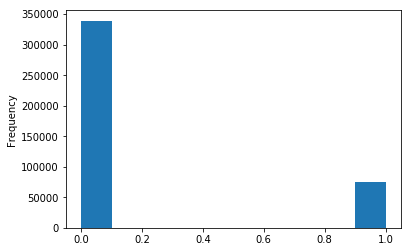

In [48]:
df["loan_status"].plot(kind="hist")

Gettig index of NA values in any numeric variable:

In [49]:
def get_na(x):
    nms=x.columns.values.tolist()
    na_ind=x[nms[0]].isna()
    for i in nms[1:]:
        na_ind=na_ind|x[i].isna()
    return na_ind

In [50]:
na_ind=get_na(df[num_vars])
df.loc[~na_ind,num_vars].isna().any().any()

False

Finding and dropping variables with the correlation over 0.8:

In [51]:
cor = abs(df.loc[~na_ind,num_vars].corr())

In [52]:
def get_corr(x,thr):
    nms=x.columns.values.tolist()
    arr=[]
    for i in nms:
        x.loc[i,i]=0
        ind=x[i]>thr
        vars=x.loc[ind,i].index.values.tolist()
        if len(vars)!=0:
            arr.append([i,vars])
    return arr

In [53]:
cor_arr=get_corr(cor,0.8)
cor_arr

[['loan_amnt', ['funded_amnt_inv', 'installment', 'total_pymnt_inv']],
 ['funded_amnt_inv', ['loan_amnt', 'installment', 'total_pymnt_inv']],
 ['int_rate', ['sub_grade']],
 ['installment', ['loan_amnt', 'funded_amnt_inv', 'total_pymnt_inv']],
 ['sub_grade', ['int_rate']],
 ['loan_status', ['good_loan']],
 ['earliest_cr_line', ['mo_sin_old_rev_tl_op']],
 ['fico_range_low', ['fico_range_high']],
 ['fico_range_high', ['fico_range_low']],
 ['open_acc', ['num_op_rev_tl', 'num_sats']],
 ['revol_bal', ['total_rev_hi_lim']],
 ['revol_util', ['bc_util']],
 ['total_pymnt_inv', ['loan_amnt', 'funded_amnt_inv', 'installment']],
 ['recoveries', ['collection_recovery_fee']],
 ['collection_recovery_fee', ['recoveries']],
 ['tot_cur_bal', ['avg_cur_bal', 'tot_hi_cred_lim']],
 ['total_rev_hi_lim', ['revol_bal']],
 ['avg_cur_bal', ['tot_cur_bal', 'tot_hi_cred_lim']],
 ['bc_open_to_buy', ['total_bc_limit']],
 ['bc_util', ['revol_util', 'percent_bc_gt_75']],
 ['mo_sin_old_rev_tl_op', ['earliest_cr_line']]

In [54]:
resp_list=[]
for ind,i in enumerate(cor_arr):
    if i[0]=="loan_status":
        resp_list=i[1]
        del cor_arr[ind]
print(resp_list)

for ind,i in enumerate(cor_arr):
    if i[0] in resp_list:
        del cor_arr[ind]

drop_cor=set()
save_cor=set()

for i in cor_arr:
    if not i[0] in drop_cor:
        save_cor.add(i[0])
        drop_cor.update(i[1])

drop_cor.update(resp_list)
print("drop: ", drop_cor)
print("save: ", save_cor)

uncor_vars=list(save_cor)

['good_loan']
drop:  {'mo_sin_old_rev_tl_op', 'total_bc_limit', 'fico_range_high', 'num_sats', 'num_rev_tl_bal_gt_0', 'total_rev_hi_lim', 'num_bc_sats', 'funded_amnt_inv', 'tot_hi_cred_lim', 'num_op_rev_tl', 'installment', 'bc_util', 'total_il_high_credit_limit', 'good_loan', 'collection_recovery_fee', 'sub_grade', 'avg_cur_bal', 'total_pymnt_inv', 'num_rev_accts'}
save:  {'total_bal_ex_mort', 'num_actv_bc_tl', 'num_bc_tl', 'fico_range_low', 'earliest_cr_line', 'tot_cur_bal', 'num_actv_rev_tl', 'loan_amnt', 'percent_bc_gt_75', 'bc_open_to_buy', 'int_rate', 'revol_util', 'recoveries', 'open_acc', 'revol_bal'}


In [55]:
df.drop(list(drop_cor),axis=1,inplace=True)
df.columns.values.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'total_rec_late_fee',
 'recoveries',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_tl',
 'num_il_tl',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'total_bal_ex_mort']

Updating list of numeric variables:

In [56]:
num_vars=list(df.dtypes[df.dtypes!=np.dtype('O')].index)

In [57]:
df.describe()

,loan_amnt,int_rate,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,...,num_il_tl,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort
count,413534.000000,413534.000000,4.135340e+05,413534.000000,413534.000000,413534.000000,413534.000000,413534.000000,413534.000000,413534.000000,...,413534.000000,403804.000000,413534.000000,413534.000000,413534.000000,413393.000000,409443.000000,413534.000000,413534.000000,4.135340e+05
mean,14403.164855,13.639690,7.392663e+04,13.862381,0.179702,17.819634,0.313882,53.490492,693.138339,0.748838,...,8.300812,0.000837,0.003277,0.085517,1.979450,94.578029,50.944594,0.129999,0.045846,4.669880e+04
std,8266.140282,4.388482,5.498279e+04,0.683788,0.383940,8.017086,0.851423,7.385449,29.260498,1.019364,...,7.154415,0.030340,0.061666,0.465747,1.619808,8.209900,34.840875,0.367329,0.378309,4.477358e+04
min,1000.000000,5.930000,3.000000e+03,13.000000,0.000000,0.000000,0.000000,0.000000,660.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.700000,0.000000,0.000000,0.000000,0.000000e+00
25%,8000.000000,10.490000,4.500000e+04,13.000000,0.000000,11.790000,0.000000,50.000000,670.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,1.000000,92.000000,22.200000,0.000000,0.000000,2.000625e+04
50%,12050.000000,13.350000,6.366500e+04,14.000000,0.000000,17.370000,0.000000,55.000000,685.000000,0.000000,...,6.000000,0.000000,0.000000,0.000000,2.000000,100.000000,50.000000,0.000000,0.000000,3.534900e+04
75%,20000.000000,16.290000,9.000000e+04,14.000000,0.000000,23.530000,0.000000,58.000000,705.000000,1.000000,...,11.000000,0.000000,0.000000,0.000000,3.000000,100.000000,80.000000,0.000000,0.000000,5.854275e+04
max,35000.000000,26.060000,8.706582e+06,15.000000,1.000000,39.990000,29.000000,68.000000,845.000000,6.000000,...,150.000000,3.000000,4.000000,24.000000,26.000000,100.000000,100.000000,12.000000,63.000000,2.688920e+06


## 3. Modelling

Getting response variable:

In [58]:
y=df["loan_status"]
df.drop(labels=["loan_status"],axis=1, inplace=True)

Splitting into the train and test sets:

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size=0.3, random_state=30, stratify=y)

Getting the list of object variables:

In [60]:
obj_vars=list(df.dtypes[df.dtypes==np.dtype('O')].index)
num_vars=list(df.dtypes[df.dtypes!=np.dtype('O')].index)
df[obj_vars].describe().T

,count,unique,top,freq
term,413534,2,36 months,318766
emp_length,392515,11,15,136937
home_ownership,413534,4,MORTGAGE,208980
verification_status,413534,3,Source Verified,144197
purpose,413534,13,debt_consolidation,249729
addr_state,413534,10,DEFAULT,183659
initial_list_status,413534,2,f,238504


Transforming them with One-Hot-Encoder in train and test sets separately. NA values of object variables are transformed in a new categories. NA values of numeric variables will be imputed in pipeline.

In [61]:
X_train=pd.concat([X_train[num_vars],
                   pd.get_dummies(
                       X_train[obj_vars],dummy_na=True)], axis=1)

X_test=pd.concat([X_test[num_vars],
                   pd.get_dummies(
                       X_test[obj_vars],dummy_na=True)], axis=1)

Comparing categories in train and test sets. dropping unique columns of test set.

In [62]:
a=set(X_train.columns.values)
b=set(X_test.columns.values)
print(a.difference(b))
print(b.difference(a))

set()
{'home_ownership_ANY'}


In [63]:

X_test.drop(labels=list(b.difference(a)),axis=1, inplace=True)
c= list(a.difference(b))
for i in c:
  X_test[i]=0

Casting dataframe into float:

In [64]:
X_train = X_train.astype(dtype="float64")
X_test = X_test.astype(dtype="float64")

Log regression pipeline with Grid Search:

In [65]:
lr_steps = [('imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('scaler', StandardScaler()),
            ('logit_reg', LogisticRegression(solver="lbfgs"))]
pl_lr = Pipeline(lr_steps) # define the pipeline object.

#lr_params = {'logit_reg__C': [1e-07*(10**i) for i in range(1,9,1)], 'logit_reg__penalty':["l2"]}
lr_params = {'logit_reg__C': [1e-03], 'logit_reg__penalty':["l2"]}

lr = GridSearchCV(pl_lr, lr_params, cv=5)
lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_...nalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logit_reg__C': [0.001], 'logit_reg__penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Score:

In [66]:
print(lr.best_params_ )
probs=lr.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))

{'logit_reg__C': 0.001, 'logit_reg__penalty': 'l2'}
auc: 0.905


Variable importance:

In [67]:
t=lr.best_estimator_
cofs=t.steps[2][1].coef_[0]
imp_ind=np.flip(np.argsort(abs(cofs)))
nms=X_train.columns.values
print("variable importance names, descending:\n",nms[imp_ind][0:5])
print("variable importance coefs, descending:\n",cofs[imp_ind][0:5])

variable importance names, descending:
 ['recoveries' 'int_rate' 'total_rec_late_fee' 'annual_inc'
 'term_ 60 months']
variable importance coefs, descending:
 [ 3.54887724  0.24900783  0.21043472 -0.18098606  0.16610287]


Decision tree pipeline:

In [68]:
tr_steps = [('imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
             ('scaler', StandardScaler()),
             ('tree', DecisionTreeClassifier(random_state=42, max_leaf_nodes=5))]
pl_tr = Pipeline(tr_steps) # define the pipeline object.
tr_params = {}
tr = GridSearchCV(pl_tr, tr_params, cv=3)
tr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=No...plit=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Score:

In [69]:
print(tr.best_params_ )
probs=tr.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))

{}
auc: 0.906


Variable importance:

In [70]:
t=tr.best_estimator_
cofs=t.steps[2][1].feature_importances_ 
imp_ind=np.flip(np.argsort(abs(cofs)))
nms=X_train.columns.values
print("variable importance names, descending:\n",nms[imp_ind][0:5])
print("variable importance coefs, descending:\n",cofs[imp_ind][0:5])

variable importance names, descending:
 ['recoveries' 'term_ 60 months' 'total_rec_late_fee' 'issue_d' 'num_il_tl']
variable importance coefs, descending:
 [0.98056015 0.0106409  0.00499186 0.0038071  0.        ]


Random forest pipeline:

In [ ]:
rf_steps = [('imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
             ('scaler', StandardScaler()),
             ('rf', RandomForestClassifier(random_state=42))]
pl_rf = Pipeline(rf_steps) # define the pipeline object.
rf_params = {}
rf = GridSearchCV(pl_rf, rf_params, cv=3)
rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, m...rs='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Score:

In [ ]:
print(rf.best_params_ )
probs=rf.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))

{}
auc: 1.000


Variable importance:

In [ ]:
t=rf.best_estimator_
cofs=t.steps[2][1].feature_importances_ 
imp_ind=np.flip(np.argsort(abs(cofs)))
nms=X_train.columns.values
print("variable importance names, descending:\n",nms[imp_ind][0:5])
print("variable importance coefs, descending:\n",cofs[imp_ind][0:5])

variable importance names, descending:
 ['recoveries' 'int_rate' 'dti' 'bc_open_to_buy' 'annual_inc']
variable importance coefs, descending:
 [0.54245405 0.02923272 0.01880208 0.01656639 0.01628662]


Gradient boosting pipeline with Grid Search:

In [ ]:
gbm_steps = [('imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier())]
pl_gbm = Pipeline(gbm_steps) # define the pipeline object.
#gbm_params = {'gbm__learning_rate': [1e-04*(10**i) for i in range(1,5,1)], 'gbm__n_estimators':[i for i in range(20,160,20)]}
gbm_params = {'gbm__learning_rate': [0.1], 'gbm__n_estimators':[100]}
gbm = GridSearchCV(pl_gbm, gbm_params, cv=3)
gbm.fit(X_train, y_train)

Score:

In [ ]:
print(gbm.best_params_ )
probs=gbm.predict_proba(X_train)[:,1]
print("auc: {0:.3f}".format(roc_auc_score(y_train,probs)))

Variable importance:

In [ ]:
t=gbm.best_estimator_
cofs=t.steps[2][1].feature_importances_ 
imp_ind=np.flip(np.argsort(abs(cofs)))
nms=X_train.columns.values
print("variable importance names, descending:\n",nms[imp_ind][0:5])
print("variable importance coefs, descending:\n",cofs[imp_ind][0:5])

## 4. Model selection

In [ ]:
def get_thr(y_test, test_probs,thr): 
    t=tpr-fpr
    ind=np.argmax(t[tpr>=thr])
    return threshold[ind]

In [ ]:
def plot_roc(y_test, test_probs,tit):
    fpr, tpr, threshold=roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(tit)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [ ]:
gbm_probs=gbm.predict_proba(X_test)[:,1]
lr_probs=lr.predict_proba(X_test)[:,1]
rf_probs=rf.predict_proba(X_test)[:,1]
tr_probs=tr.predict_proba(X_test)[:,1]
probs_arr=[lr_probs,tr_probs,rf_probs,gbm_probs]
nms=["Logistic regression","Decision Tree","Random Forest","GBM"]
for ind,i in enumerate(probs_arr):
    plot_roc(y_test, i,nms[ind])